In [1]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import nltk
from nltk.tokenize import RegexpTokenizer


In [2]:
df_test = pd.read_csv('../datasets/test set/full_test_sep.tsv', sep='\t')
df_icf = pd.read_csv('../datasets/ICF/ICF_def_label.tsv', sep='\t')
df_icf_level2 = pd.read_csv('../datasets/ICF/ICF_level2_def_label.tsv', sep='\t')

In [3]:
icf_def_level2 = df_icf_level2['def-level2'].tolist() # exclude the none label def
labels_level2 = df_icf_level2['label-level2']
labels_level1 = df_icf['label'].tolist()
sentence = df_test['utterances'].tolist()

# transform label to num
df_test.loc[df_test['gold'] == 'learning', 'gold'] = 0
df_test.loc[df_test['gold'] == 'general', 'gold'] = 1
df_test.loc[df_test['gold'] == 'communication', 'gold'] = 2
df_test.loc[df_test['gold'] == 'mobility', 'gold'] = 3
df_test.loc[df_test['gold'] == 'selfcare', 'gold'] = 4
df_test.loc[df_test['gold'] == 'domestic', 'gold'] = 5
df_test.loc[df_test['gold'] == 'interpersonal', 'gold'] = 6
df_test.loc[df_test['gold'] == 'major', 'gold'] = 7
df_test.loc[df_test['gold'] == 'social', 'gold'] = 8
df_test.loc[df_test['gold'] == 'none', 'gold'] = 9


checklabel = [0,1,2,3,4,5,6,7,8,9]
gold = df_test['gold'].tolist()
for n,i in enumerate(gold):
    if i not in checklabel:
        if i != '-'*20:
            print(i,n)
print('clean test set labels')


clean test set labels


In [4]:
if '-'*20 in sentence:
    print('with sep processing')
    sentence = [ i for i in sentence if i != '-'*20]

if '-'*20 in gold:
    print('with sep processing')
    gold = [ i for i in gold if i != '-'*20]

with sep processing
with sep processing


In [5]:
icf_def_level2

['Purposeful sensory experiences is about  Watching, Listening, Mouthing, Touching, Smelling, Tasting.',
 'Basic learning is about Copying, Learning through actions with objects, Acquiring language, Acquiring additional,  language, Rehearsing, Acquiring concepts, Acquiring information, Learning to read, Learning to write, Learning to calculate, Acquiring skills',
 'Applying knowledge is about Focusing attention, Thinking, Reading, Writing, Calculating, Solving problems, Making decisions',
 'Undertaking a single task is about Carrying out simple or complex and coordinated actions related to the mental and physical components of a single task, such as initiating a task, organizing time, space and materials for a task, pacing task performance, and carrying out, completing, and sustaining a task.',
 'Undertaking multiple tasks is about Carrying out simple or complex and coordinated actions as components of multiple, integrated and complex tasks in sequence or simultaneously.',
 'Carrying o

In [6]:
print('num of def:', len(icf_def_level2))
print('num of level1 labels:', len(labels_level1))
print('num of level2 labels:', len(labels_level2))
print('num of test sentences:',len(sentence))

num of def: 34
num of level1 labels: 10
num of level2 labels: 34
num of test sentences: 583


#### preprocess
- lower casing
- remove punctuation
- lemmatization
- remove stopwords
- tf-idf

In [7]:
with open ("../datasets/ICF/icf_level123_def.txt",'r',encoding='utf-8') as infile:
    raw_level123_def = infile.read()

In [8]:
level123_def = raw_level123_def.split('.')
print('num of train sentences:', len(level123_def))

num of train sentences: 320


In [9]:
# Preprocess
# import nltk
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import RegexpTokenizer
# from nltk.corpus import stopwords

def preprocess_text(list_of_sentence):
    """
    """
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    stop_words = [w.lower() for w in stopwords.words('english')]
    processed = []
    for s in list_of_sentence:
        s = s.lower()
        clean_tokens = [lemmatizer.lemmatize(t) for t in word_tokenize(s) if t not in stop_words]
        s = ' '.join(clean_tokens)
        processed.append(s)

    return processed

In [10]:
# from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer(lowercase=True)

#preprocess
train = preprocess_text(level123_def)
test = preprocess_text(sentence)
level_2 = preprocess_text(icf_def_level2)

# Train the model
X_train = train
model.fit(X_train)
print('corpus vocab size:', len(model.vocabulary_.keys()))

# Generate Embeddings on Test
sentence1_emb = model.transform(test)
sentence2_emb = model.transform(level_2)

# Cosine Similarity
all_cos_score = cosine_similarity(sentence1_emb, sentence2_emb)
print('score dimension:', all_cos_score.shape)

# https://towardsdatascience.com/semantic-textual-similarity-83b3ca4a840e

corpus vocab size: 1531
score dimension: (583, 34)


In [11]:
# all_cos_score = all_cos_score.tolist()
max_cos = ["%.2f" % np.max(all_cos_score, axis = None)]
max_score_each_row = ["%.3f" % n for n in np.amax(all_cos_score, axis = 1)]
max_score_each_row = [float(n) for n in max_score_each_row]
max_score_ind = np.argmax(all_cos_score, axis =1)
print(len(max_score_each_row) == len(max_score_ind))
print('max cos:', max_cos)
print('max cos of each row:', 'total rows:', len(max_score_each_row))
print(max_score_each_row)
print('-'*20)
print('max cos index of each row:', 'total rows:', len(max_score_ind))
print(max_score_ind)
# max_score, max_score_ind

True
max cos: ['0.70']
max cos of each row: total rows: 583
[0.695, 0.0, 0.0, 0.35, 0.297, 0.495, 0.0, 0.297, 0.0, 0.0, 0.0, 0.046, 0.0, 0.0, 0.0, 0.192, 0.129, 0.122, 0.135, 0.208, 0.185, 0.0, 0.0, 0.0, 0.0, 0.29, 0.242, 0.0, 0.164, 0.0, 0.038, 0.028, 0.0, 0.0, 0.206, 0.056, 0.0, 0.126, 0.065, 0.0, 0.0, 0.0, 0.135, 0.0, 0.11, 0.695, 0.158, 0.565, 0.0, 0.0, 0.255, 0.0, 0.037, 0.07, 0.0, 0.0, 0.136, 0.167, 0.239, 0.0, 0.495, 0.275, 0.0, 0.072, 0.125, 0.209, 0.632, 0.0, 0.087, 0.306, 0.0, 0.0, 0.0, 0.209, 0.0, 0.0, 0.0, 0.153, 0.211, 0.156, 0.0, 0.442, 0.0, 0.166, 0.0, 0.077, 0.0, 0.0, 0.214, 0.524, 0.0, 0.0, 0.0, 0.0, 0.311, 0.25, 0.215, 0.0, 0.0, 0.306, 0.284, 0.0, 0.0, 0.278, 0.0, 0.0, 0.38, 0.139, 0.246, 0.216, 0.0, 0.297, 0.0, 0.0, 0.212, 0.157, 0.235, 0.0, 0.0, 0.0, 0.15, 0.153, 0.0, 0.0, 0.239, 0.0, 0.0, 0.0, 0.204, 0.105, 0.0, 0.0, 0.09, 0.0, 0.0, 0.0, 0.333, 0.119, 0.0, 0.0, 0.0, 0.385, 0.199, 0.0, 0.0, 0.329, 0.0, 0.0, 0.0, 0.0, 0.282, 0.097, 0.0, 0.0, 0.235, 0.0, 0.0, 0.067, 0

In [12]:
# convert level 2 labels to level 1 labels so that we can evaluate the predictions with the test set label
# convert list
learning_0 = [0,1,2]
general_1 = [3,4,5,6]
communication_2 = [7,8,9]
mobility_3 = [10,11,12,13]
selfcare_4 = [14,15,16,17,18,19,20]
domestic_5 = [21,22,23]
interpersonal_6 = [24,25]
major_7 = [26,27,28]
social_8 = [29,30,31,32,33]

# convert_list = [learning_0, general_1, communication_2, mobility_3, selfcare_4, domestic_5, interpersonal_6, major_7, social_8]

converted_max_score_ind = []
for ind in max_score_ind:
    if ind in learning_0:
        converted_max_score_ind.append(0)
    elif ind in general_1:
        converted_max_score_ind.append(1)
    elif ind in communication_2:
        converted_max_score_ind.append(2)
    elif ind in mobility_3:
        converted_max_score_ind.append(3)
    elif ind in selfcare_4:
        converted_max_score_ind.append(4)
    elif ind in domestic_5:
        converted_max_score_ind.append(5)
    elif ind in interpersonal_6:
        converted_max_score_ind.append(6)
    elif ind in major_7:
        converted_max_score_ind.append(7)
    elif ind in social_8:
        converted_max_score_ind.append(8)
    else:
        print('wrong range')
        
print('same len before and after converted:', len(max_score_ind)==len(converted_max_score_ind))


same len before and after converted: True


In [13]:
# add how to convert the possibility to label section
# get prediction
# from sklearn.metrics import f1_score

zip_scor_ind = list(zip(max_score_each_row, converted_max_score_ind))

def get_predictions(zip_scor_ind, threshold):
    """"""
    # threshold = 0.10
    predictions = []
    for s, i in zip_scor_ind:
        if s >= threshold:
            predictions.append(i)
        elif s < threshold:
            predictions.append(9) # index 9 means 'none'
        else:
            print('error comparison')
    return predictions

def get_best_fscore(thresholdlist, zip_scor_ind, gold):
    """"""
    list_fscore = []
    for threshold in thresholdlist:
        predictions = get_predictions(zip_scor_ind, threshold)
        list_fscore.append(f1_score(gold, predictions,average='macro'))
    # print(list_fscore)
    # print(type(list_fscore[1]))
    max_fsc = max(list_fscore)
    best_thres = thresholdlist[list_fscore.index(max(list_fscore))]
    return(max_fsc, best_thres)

# predictions = get_predictions(zip_scor_ind, threshold=0.1)
thresholdlist = [0.02, 0.1, 0.2, 0.25, 0.3,0.4,0.5,0.6,0.7,0.8,0.9]
max_fsc, best_thres = get_best_fscore(thresholdlist, zip_scor_ind, gold)
print('threshold list:',thresholdlist)
print('max-macro fscore:', '%.3f' % max_fsc)
print('best threshold',best_thres)
#


threshold list: [0.02, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max-macro fscore: 0.257
best threshold 0.02


In [14]:
# get classification report 
predictions = get_predictions(zip_scor_ind, best_thres)
confusion = confusion_matrix(gold, predictions)
report = classification_report(gold, predictions)

print(report)

              precision    recall  f1-score   support

           0       0.18      0.11      0.14        27
           1       0.13      0.27      0.17        33
           2       0.33      0.22      0.27        18
           3       0.23      0.13      0.17        45
           4       0.13      0.29      0.18        31
           5       0.45      0.19      0.27        77
           6       0.71      0.07      0.14        67
           7       0.34      0.37      0.36        35
           8       0.44      0.26      0.33        57
           9       0.47      0.67      0.55       193

    accuracy                           0.36       583
   macro avg       0.34      0.26      0.26       583
weighted avg       0.41      0.36      0.34       583



In [15]:
for i, label in enumerate(labels_level1):
    print(i,label)

0 learning 
1 general 
2 communication
3 mobility
4 selfcare 
5 domestic 
6 interpersonal 
7 major
8 social
9 none 


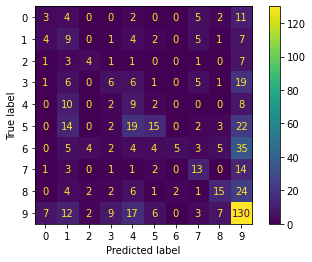

In [16]:
# plot confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,display_labels=checklabel)
disp.plot()
plt.show()

In [17]:
model = 'BOW'
df_predictions = pd.DataFrame({
    'utterances':sentence,
    'predictions':predictions
    })
df_predictions.to_csv(f'../datasets/predictions/predictions_{model}_level_2.tsv', sep='\t',index=None)